# Web scrawl and NPL

* scrape text from [The California Aggie](https://theaggie.org/) and then analyze the text.

The Aggie is organized by category into article lists. For example, there's a [Campus News](https://theaggie.org/campus/) list, [Arts & Culture](https://theaggie.org/arts/) list, and [Sports](https://theaggie.org/sports/) list. Notice that each list has multiple pages, with a maximum of 15 articles per page.


In [1]:
import requests
import requests_cache
import lxml.html as lx
import pandas as pd
import os.path

requests_cache.install_cache('cache')

In [2]:
def extract_url(url,page="1"):
    """extract urls from the Aggie website
    input:
        url: the URL of the article list
        page: the page of article list, default is 1
        
    output:
        a list of aricle URLs 
    """
    page = str(page)
    url = os.path.join(url, "page",page)
    response = requests.get(url)
    html = lx.fromstring(response.text)
    href = html.xpath("//div[@class='entry-content-media']/a/@href")
    
    return href

In [327]:
extract_url("https://theaggie.org/campus","4")

['https://theaggie.org/2017/01/23/napolitano-to-reinforce-tentative-plans-to-expand-uc-davis-into-sacramento/',
 'https://theaggie.org/2017/01/23/former-chancellor-turns-down-feminist-leadership-role-at-uc-davis/',
 'https://theaggie.org/2017/01/22/sierra-nevada-brewing-owners-gift-2-million-to-uc-davis-program/',
 'https://theaggie.org/2017/01/22/interim-chancellor-hexter-uc-leaders-sign-letter-to-urge-action-against-climate-change/',
 'https://theaggie.org/2017/01/22/california-schools-press-donald-trump-to-continue-daca-as-president/',
 'https://theaggie.org/2017/01/22/uc-wide-walkout-teach-ins-on-trumps-inauguration-day/',
 'https://theaggie.org/2017/01/20/protests-erupt-at-milo-yiannopoulos-event/',
 'https://theaggie.org/2017/01/20/student-organizers-host-changethe-conversation-event/',
 'https://theaggie.org/2017/01/19/uc-president-janet-napolitano-hospitalized/',
 'https://theaggie.org/2017/01/17/uc-davis-appoints-new-chief-of-nursing-and-patient-care-services/',
 'https://thea

In [419]:
def extract_content(url):
    """extract the main text from an website article
    
    input:
        url: the URL of the article
        
    output:
        url: the url of the article
        title: the title of the article
        text: main content of the article
        author: author of the article        
    """
    page = requests.get(url)
    html = lx.fromstring(page.text)
    article = html.xpath("//main/article")[0]
    #if len(article)==1:
    title = article.xpath("//header/h1")[0]
    titlecontent = title.text_content()
    textlist = [x.text_content().strip() for x in article.xpath("//article//p")]
    try:
        text = " ".join(textlist).translate({ 0x2018:0x27, 0x2019:0x27, 0x201C:0x22, 0x201D:0x22, 0x2026:0x20 })
    except:
        text = " ".join(textlist)
    authorstart = text.lower().find("written by:")
    author = text[authorstart:]
    textcontent = text[:authorstart]
    return {"author": author, "text": textcontent, "title":titlecontent,"url":url}

In [420]:
extract_content("https://theaggie.org/2016/11/22/police-logs-4/")

{'author': u'Written By: Sam Solomon \u2014 city@theaggie.org',
 'text': u'Nov. 7 "Subject stated our pizza is ready and that we were supposed to order him food" Nov. 7 "Family members punching one another and trying to choke hold" Nov. 7 "Unknown male subject hit the RP\'s daughter in the head with a golf ball" Nov. 7 "Two HBD subjects threw tacos and smashed the RP\'s window" Nov. 8 "Fairly large tumbleweed blocking right lane" ',
 'title': 'Police Logs',
 'url': 'https://theaggie.org/2016/11/22/police-logs-4/'}

In [421]:
extract_content("https://theaggie.org/2017/02/14/project-toto-aims-to-address-questions-regarding-city-finances/")

{'author': u'Written By: Bianca Antunez \xa0\u2014\xa0city@theaggie.org',
 'text': u'Davis residents create financial model to make city\'s financial state more transparent To increase transparency between the city\'s financial situation and the community, three residents created a model called Project Toto which aims to improve how the city communicates its finances in an easily accessible design. Jeff Miller and Matt Williams, who are members of Davis\' Finance and Budget Commission, joined together with Davis entrepreneur Bob Fung to create the model plan to bring the project to the Finance and Budget Commission in February, according to Kelly Stachowicz, assistant city manager. "City staff appreciate the efforts that have gone into this, and the interest in trying to look at the city\'s potential financial position over the long term," Stachowicz said in an email interview. "We all have a shared goal to plan for a sound fiscal future with few surprises. We believe the Project Toto 

### Get a data frame of 60 Campus News articles and City News

In [4]:
def datacombination(url):
    """combine article information from the article list
    
    input:
        url: the url for article list
        
    output:
        carticle: dataframe of articles information
    """
    curl = [extract_url(url,i+1) for i in range(4)]
    f = lambda x,y: x+y
    curl = reduce(f, curl)
    carticlelist = [extract_content(url) for url in curl]
    carticle = pd.DataFrame(carticlelist)
    return carticle

In [5]:
campusdata = datacombination("https://theaggie.org/campus/")
campusdata["category"] = "campus"
citydata = datacombination("https://theaggie.org/city/")
citydata["category"] = "city"
datatotal = pd.concat([campusdata,citydata],ignore_index=True)

In [425]:
datatotal[:10] #the final dataframe

,author,text,title,url,category
0,Written by: Alyssa Vandenberg — campus@theagg...,"Six senators, new executive team elected Curre...",2017 Winter Quarter election results,https://theaggie.org/2017/02/24/2017-winter-qu...,campus
1,Written by: Aaron Liss and Raul Castellanos —...,"Wells Fargo faces fraud, predatory lending cha...","University of California, Davis City Council s...",https://theaggie.org/2017/02/23/university-of-...,campus
2,Written by: Kimia Akbari — campus@theaggie.org,"Faculty, students recount personal tales of im...",Academics unite in peaceful rally against immi...,https://theaggie.org/2017/02/23/academics-unit...,campus
3,Written by: Kenton Goldsby — campus@theaggie.org,Opening date pushed back to May 1 Students hav...,Memorial Union to reopen Spring Quarter,https://theaggie.org/2017/02/23/memorial-union...,campus
4,Written by: Ivan Valenzuela — campus@theaggie.org,Veto included revision abandoning creation of ...,ASUCD President Alex Lee vetoes amendment for ...,https://theaggie.org/2017/02/23/asucd-presiden...,campus
5,Written by: Alyssa Vandenberg — campus@theagg...,"Shaheen's name to remain on ballot, his votes ...",Senate candidate Zaki Shaheen withdraws from race,https://theaggie.org/2017/02/22/senate-candida...,campus
6,Written by: Aaron Liss — campus@theaggie.org,Students receive email warnings from UC Davis ...,UC Davis experiences several recent hate-based...,https://theaggie.org/2017/02/21/uc-davis-exper...,campus
7,Written by: Alyssa Vandenberg — campus@theagg...,UC Board of Regents to vote on the appointment...,UC President selects Gary May as new UC Davis ...,https://theaggie.org/2017/02/21/uc-president-s...,campus
8,Written by: Jeanna Totah — campus@theaggie.org,Tighter policies require greater approval of o...,Katehi controversy prompts decline of UC admin...,https://theaggie.org/2017/02/20/katehi-controv...,campus
9,Written by: Ivan Valenzuela — campus@theaggie...,SR #7 asks university to increase capacity for...,ASUCD Senate passes resolution submitting comm...,https://theaggie.org/2017/02/20/asucd-senate-p...,campus



### discussion part

* What topics does the Aggie cover the most? Do city articles typically cover different topics than campus articles?

* What are the titles of the top 3 pairs of most similar articles? Examine each pair of articles. What words do they have in common?

* Is this corpus representative of the Aggie? What kinds of inference can this corpus support? 


In [6]:
import numpy as np
import nltk
from nltk import corpus
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors
from matplotlib import pyplot as plt
from __future__ import division
from nltk.corpus import stopwords
from collections import Counter
import string
import unicodedata
import sys
plt.style.use('ggplot')

In [426]:
def text_clean(raw):
    """clean a text including stopwords, punctuation, and then stem
    
    Input:
        raw : raw text
        
    Output:
        stemwords: stemed words
    """
    tbl = dict.fromkeys(i for i in xrange(sys.maxunicode)
                      if unicodedata.category(unichr(i)).startswith('P'))
    raw = raw.translate(tbl)
    raw = ''.join([i for i in raw if not i.isdigit()])
    cachedStopWords = stopwords.words("english")
    tokens = nltk.word_tokenize(raw.lower())
    text = ' '.join([word for word in tokens if word not in cachedStopWords])
    words = [word for word in tokens if word not in cachedStopWords]
    porter = nltk.PorterStemmer()
    stemwords = [porter.stem(w) for w in words]
    return stemwords

In [314]:
#results of text_clean
text_clean(datatotal.text.ix[14])

[u'confer',
 u'entail',
 u'full',
 u'day',
 u'speaker',
 u'panel',
 u'studentl',
 u'discuss',
 u'uc',
 u'davi',
 u'held',
 u'first',
 u'mental',
 u'health',
 u'confer',
 u'uc',
 u'davi',
 u'confer',
 u'center',
 u'pm',
 u'sunday',
 u'feb',
 u'student',
 u'particip',
 u'seri',
 u'workshop',
 u'panel',
 u'set',
 u'activ',
 u'checkin',
 u'breakfast',
 u'open',
 u'remark',
 u'given',
 u'monica',
 u'porter',
 u'attorney',
 u'disabl',
 u'right',
 u'advoc',
 u'organ',
 u'porter',
 u'spoke',
 u'briefli',
 u'experi',
 u'mental',
 u'health',
 u'express',
 u'happi',
 u'see',
 u'mani',
 u'student',
 u'particip',
 u'mental',
 u'health',
 u'confer',
 u'speak',
 u'openli',
 u'mental',
 u'ill',
 u'without',
 u'fear',
 u'stigma',
 u'first',
 u'workshop',
 u'set',
 u'offer',
 u'student',
 u'choic',
 u'workshop',
 u'grief',
 u'minor',
 u'mental',
 u'health',
 u'intersect',
 u'approach',
 u'heal',
 u'polit',
 u'activ',
 u'trump',
 u'presid',
 u'anastasia',
 u'ruttkay',
 u'fourthyear',
 u'intern',
 u'relat

In [427]:
stemmer = PorterStemmer().stem

tokenize = nltk.word_tokenize

def stem(tokens,stemmer = PorterStemmer().stem):
    return [stemmer(w.lower()) for w in tokens] 

def lemmatize(text):
    """Extract simple lemmas based on tokenization and stemming
    
    Input: string
    Output: list of strings (lemmata)
    """
    tbl = dict.fromkeys(i for i in xrange(sys.maxunicode)
                      if unicodedata.category(unichr(i)).startswith('P'))
    text = text.translate(tbl)
    #text = re.sub(r'[^\w\s]','',text)
    text = ''.join([i for i in text if not i.isdigit()])
    return stem(tokenize(text))

In [428]:
vectorizer = TfidfVectorizer(tokenizer=lemmatize,stop_words="english",smooth_idf=True,norm=None)
corpus = datatotal.text
tfs = vectorizer.fit_transform(corpus)

In [429]:
index = [(-tfs[i].toarray()).argsort()[0][:20] for i in range(120)]
keywords = [[vectorizer.get_feature_names()[i] for i in j] for j in index]

In [430]:
keywordframe = pd.DataFrame(keywords)
f = lambda x,y: x+y
rawkeywords = reduce(f, keywords)
Counter(rawkeywords).most_common(20)

[(u'davi', 35),
 (u'student', 34),
 (u'uc', 24),
 (u'wa', 17),
 (u'event', 14),
 (u'asucd', 12),
 (u'citi', 11),
 (u'senat', 11),
 (u'protest', 10),
 (u'said', 10),
 (u'hi', 10),
 (u'support', 8),
 (u'commun', 8),
 (u'counti', 7),
 (u'univers', 7),
 (u'polici', 7),
 (u'food', 7),
 (u'program', 7),
 (u'famili', 7),
 (u'research', 7)]

The most common topics in the Aggie are davis, student, uc, wa and event. The rest words could be seen above: it shows the most common 20 words in the Aggie news.

In [431]:
def counterkey(keywords,num):
    rawkeywords = reduce(f,keywords)
    counter_selected = dict(Counter(rawkeywords).most_common(num))
    counterkey = counter_selected.keys()
    return set(counterkey)

In [440]:
keywordscampus = keywords[:60]
keywordscity = keywords[60:]
counterkey(keywordscampus,20) & counterkey(keywordscity,20)

{u'davi', u'event', u'student', u'wa'}

I split the topics into campus part and city part, and it implies that there are few same words in the top 20 typical or important words between campus and city news: <strong>davis, event student</strong> and <strong>wa</strong>. So city articles basically cover different topics than campus articles.

In [436]:
def keywords_graph(keywords,num=20):
    """organize keywords for graph 
        
        input: 
        keywords: raw keyword data
        num: the number of common keywords we want to extract
        
        output: dataframe including words and their frequency
    """
    rawkeywords = reduce(f,keywords)
    data = pd.DataFrame.from_dict(dict(Counter(rawkeywords).most_common(num)), orient='index', dtype=None)
    data['word']=data.index
    data.index = range(num)
    data.columns = ["number","word"]
    return data

In [442]:
campus = keywords_graph(keywordscampus,20)
city = keywords_graph(keywordscity,20)

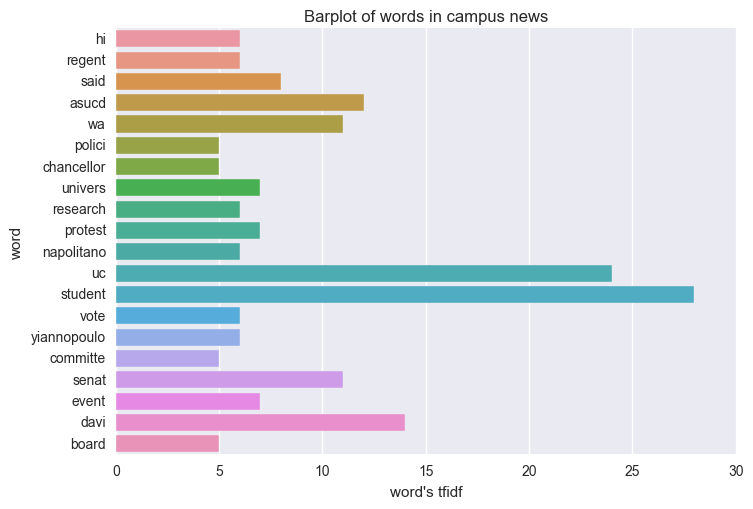

In [444]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.barplot(x = "number",y = "word",data = campus)
plt.title('Barplot of words in campus news')
plt.xlabel("word's tfidf")
plt.show()

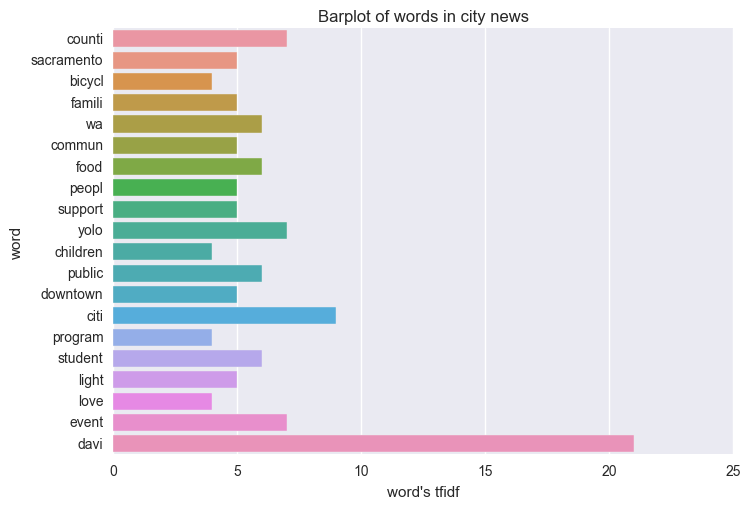

In [445]:
sns.barplot(x = "number",y = "word",data = city)
plt.title('Barplot of words in city news')
plt.xlabel("word's tfidf")
plt.show()

These two barplots shows the frequency of most typical words in campus articles and city articles seperately. And the line plot below implies the common words in these two common-word dictionary. Obviously, their frenquency are quite different.

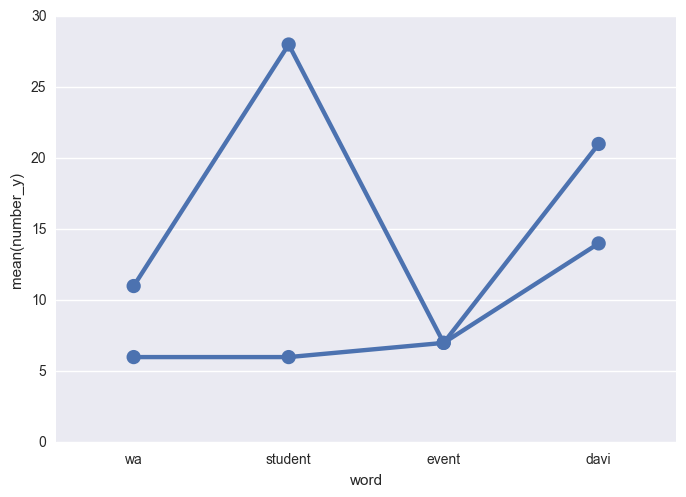

In [481]:
campus["category"] = "campus"
city["category"] = "city"
commonset = pd.concat([campus,city])
common = pd.merge(campus,city,on = "word")
sns.set_color_codes("muted")
sns.pointplot(x="word",y="number_x",data=common,col="g",markers=["o"])
sns.pointplot(x="word",y="number_y",data=common,col="#bb3f3f",nmarkers =["+"])
plt.show()

In [482]:
simmat = tfs.dot(tfs.T)
simarray = simmat.toarray()
simarray = np.triu(simarray,1)
rankindex = simarray.argsort(axis=None)
rankindex[-3:]

array([1696,  505, 1715])

In [488]:
def xy_index(num, ncol):
    x = num//ncol
    y = num % ncol
    return (x,y)

In [490]:
print xy_index(1715,120)
print xy_index(505,120)
print xy_index(1696,120)

(14, 35)
(4, 25)
(14, 16)


<p>By using the tfs vector straightly, we can figure out the index of top 3 pairs of most similar articles are (14, 35), (4, 25), (14, 16). But it's not quite understandable according to the result. So we use cos similarity to improve the algorithm. And the results are shown in the same way.</p>

In [483]:
from sklearn.metrics.pairwise import cosine_similarity
simarray2 = cosine_similarity(tfs)
simarray2 = np.triu(simarray2,1)
rankindex2 = simarray2.argsort(axis=None)
rankindex2[-3:]

array([6178, 2918, 1715])

In [492]:
print xy_index(1715,120)
print xy_index(2918,120)
print xy_index(6178,120)

(14, 35)
(24, 38)
(51, 58)


<p>So the top 3 pairs of most similar articles are:</p>
1.  UC Davis holds first mental health conference <br /> UC Davis to host first ever mental health conference
2.  Davis College Republicans club leads protest against cancellation of Milo Yiannopoulos event <br />  Protests erupt at Milo Yiannopoulos event
3.  University of California Regents meet, approve first tuition raise in six years <br />  UC Regents vote to raise tuition for UC campuses

And the common words between them are listed in the result of function "compare".

In [521]:
def compare(id1,id2,tfs):
    title1 = datatotal.title[id1]
    title2 = datatotal.title[id2]
    #another type to find common words
    #words1 = set(text_clean(datatotal.text.ix[id1]))
    #words2 = set(text_clean(datatotal.text.ix[id2]))
    #commonwords = words1 & words2
    array1 = tfs.toarray()[id1]* tfs.toarray()[id2]
    length_words = len([i for i in array1 if i!=0.0])
    index = array1.argsort()[-length_words:]
    commonwords2 = [vectorizer.get_feature_names()[i] for i in index ]
    return {"title1":title1,"title2":title2,"common words":commonwords2}

In [536]:
articlepair1 = compare(14,35,tfs)
articlepair2 = compare(24,38,tfs)
articlepair3 = compare(51,58,tfs)
articlepair1
pd.DataFrame([articlepair1,articlepair2,articlepair3])

,common words,title1,title2
0,"[thi, use, center, involv, feb, month, come, s...",UC Davis holds first mental health conference,UC Davis to host first ever mental health conf...
1,"[jan, sinc, servic, place, new, presid, wa, as...","University of California Regents meet, approve...",UC Regents vote to raise tuition for UC campuses
2,"[thi, major, student, local, veri, feel, howev...",Protests erupt at Milo Yiannopoulos event,Davis College Republicans club leads protest a...



<p> Basically, I believe that this corpus is representative. Because when we see the most common topics, they are all about student events in UCDavis and daily life in davis. And our conclusions based on this corpus fit the common sense and basic information we know about the Aggie. This corpus is gotten according to the latest articles post online, so it's useful for fully understand of the development in davis and the futhur study of the Aggie articles.</p>
<p>Besides from the results we already know, this corpus can be used for the check of the category of some articles, if we don't know where to put the article online. And we may use it to correct spelling if we use tokens rather than lemmatized words. Obivously, we can use it to inference some events which will happen in the near future.</p>